In [ ]:
%%capture
!pip install transformers
!pip install numpy
!pip install datasets
!pip install sklearn
!pip install pandas
!pip install sklearn
!pip install umap-learn 
!pip install torch
!pip install huggingface_hub


In [ ]:
from huggingface_hub import notebook_login

notebook_login()

Login successful
Your token has been saved to /root/.huggingface/token
Authenticated through git-credential store but this isn't the helper defined on your machine.
You might have to re-authenticate when pushing to the Hugging Face Hub. Run the following command in your terminal in case you want to set this credential helper as the default

git config --global credential.helper store


In [ ]:
from datasets import load_dataset

news = load_dataset("ag_news")
# news = load_dataset("emotion")

Using custom data configuration default


Generating train split:   0%|          | 0/120000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/7600 [00:00<?, ? examples/s]

Dataset ag_news downloaded and prepared to /root/.cache/huggingface/datasets/ag_news/default/0.0.0/bc2bcb40336ace1a0374767fc29bb0296cdaf8a6da7298436239c54d79180548. Subsequent calls will reuse this data.


  0%|          | 0/2 [00:00<?, ?it/s]

In [ ]:
import pandas as pd
news.set_format(type="pandas")
df = news["train"][:]
df.head()

,text,label
0,Wall St. Bears Claw Back Into the Black (Reute...,2
1,Carlyle Looks Toward Commercial Aerospace (Reu...,2
2,Oil and Economy Cloud Stocks' Outlook (Reuters...,2
3,Iraq Halts Oil Exports from Main Southern Pipe...,2
4,"Oil prices soar to all-time record, posing new...",2


In [ ]:
def label_int2str(row):
  return news["train"].features["label"].int2str(row)

df["label_name"] = df["label"].apply(label_int2str)
df.head()

,text,label,label_name
0,Wall St. Bears Claw Back Into the Black (Reute...,2,Business
1,Carlyle Looks Toward Commercial Aerospace (Reu...,2,Business
2,Oil and Economy Cloud Stocks' Outlook (Reuters...,2,Business
3,Iraq Halts Oil Exports from Main Southern Pipe...,2,Business
4,"Oil prices soar to all-time record, posing new...",2,Business


In [ ]:
# from dataframe back to huggingface standard
news.reset_format()

In [ ]:
from transformers import AutoTokenizer

# model_name = "distilbert-base-uncased-finetuned-sst-2-english"
model_name = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/483 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

In [ ]:
def tokenize_batch(batch):
  return tokenizer(batch["text"], padding=True, truncation=True)

In [ ]:
news_encoded = news.map(tokenize_batch, batched=True, batch_size=None)

Parameter 'function'=<function tokenize_batch at 0x7f98ae07ccb0> of the transform datasets.arrow_dataset.Dataset._map_single couldn't be hashed properly, a random hash was used instead. Make sure your transforms and parameters are serializable with pickle or dill for the dataset fingerprinting and caching to work. If you reuse this transform, the caching mechanism will consider it to be different from the previous calls and recompute everything. This warning is only showed once. Subsequent hashing failures won't be showed.


  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

In [ ]:
from transformers import AutoModel
from torch import device, cuda
# model_ckpt = "distilbert-base-uncased-finetuned-sst-2-english"
model_ckpt = "distilbert-base-uncased"

device = device("cuda" if cuda.is_available() else "cpu")
model = AutoModel.from_pretrained(model_ckpt).to(device)

Downloading:   0%|          | 0.00/256M [00:00<?, ?B/s]

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_projector.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
from torch import no_grad
def extract_hidden_states(batch):
    # Place model inputs on the GPU
    inputs = {k:v.to(device) for k,v in batch.items() 
              if k in tokenizer.model_input_names}
    # Extract last hidden states
    with no_grad():
        last_hidden_state = model(**inputs).last_hidden_state
    # Return vector for [CLS] token
    return {"hidden_state": last_hidden_state[:,0].cpu().numpy()}

In [ ]:
news_encoded.set_format("torch", 
                            columns=["input_ids", "attention_mask", "label"])

In [ ]:
news_hidden = news_encoded.map(extract_hidden_states, batched=True, batch_size=200)

  0%|          | 0/600 [00:00<?, ?ba/s]

  0%|          | 0/38 [00:00<?, ?ba/s]

In [ ]:
import numpy as np

X_train = np.array(news_hidden["train"]["hidden_state"])
X_valid = np.array(news_hidden["test"]["hidden_state"])
y_train = np.array(news_hidden["train"]["label"])
y_valid = np.array(news_hidden["test"]["label"])
X_train.shape, X_valid.shape

((120000, 768), (7600, 768))

## Build baseline models
- Logistic Regression
- Random Forrest
- SVM

These should show whether or not it makes sense to use a Neural Net. If it does, cool. If not, use the best performer here. Hypothesis is Random Forrest because it has the greatest variety. SVM could work too because it thrives in high dimension spaces

Logistic regression performed best. Occam's Razor. **also had the most iterations** 

Sports is the most predictable category across all confusion matrices. 
Business and science produced the most unreliable estimates acrooss all matricies

In [ ]:
from sklearn.linear_model import LogisticRegression

lr_clf = LogisticRegression(max_iter=3000)
lr_clf.fit(X_train, y_train)

LogisticRegression(max_iter=3000)

In [ ]:
from sklearn.ensemble import RandomForestClassifier

rf_clf = RandomForestClassifier()
rf_clf.fit(X_train, y_train)

RandomForestClassifier()

In [ ]:
lr_clf.score(X_valid, y_valid)
rf_clf.score(X_valid, y_valid)

0.8953947368421052

In [ ]:
lr_clf.score(X_valid, y_valid)


0.911578947368421

In [ ]:
from sklearn import svm

svm_clf = svm.SVC()
svm_clf.fit(X_valid, y_valid)

SVC()

In [ ]:
svm_clf.score(X_valid, y_valid)

0.9092105263157895

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
import matplotlib.pyplot as plt


labels = news["train"].features["label"].names

def plot_confusion_matrix(y_preds, y_true, labels):
    cm = confusion_matrix(y_true, y_preds, normalize="true")
    fig, ax = plt.subplots(figsize=(6, 6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False)
    plt.title("Normalized confusion matrix")
    plt.show()
    
y_preds_lr = lr_clf.predict(X_valid)
y_preds_rf = rf_clf.predict(X_valid)
y_preds_svm = svm_clf.predict(X_valid)
plot_confusion_matrix(y_preds_lr, y_valid, labels)
plot_confusion_matrix(y_preds_rf, y_valid, labels)
plot_confusion_matrix(y_preds_svm, y_valid, labels)

KeyboardInterrupt: ignored

In [ ]:
from transformers import AutoModelForSequenceClassification

num_labels = 4
model = (AutoModelForSequenceClassification
         .from_pretrained(model_ckpt, num_labels=num_labels)
         .to(device))

In [ ]:
from sklearn.metrics import accuracy_score, f1_score

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    f1 = f1_score(labels, preds, average="weighted")
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc, "f1": f1}


## Train the model

In [ ]:
from transformers import Trainer, TrainingArguments

batch_size = 32
logging_steps = len(news_encoded["train"]) // batch_size
model_name = f"{model_ckpt}-finetuned-news"
training_args = TrainingArguments(output_dir=model_name,
                                  num_train_epochs=2,
                                  learning_rate=2e-4,
                                  per_device_train_batch_size=batch_size,
                                  per_device_eval_batch_size=batch_size,
                                  weight_decay=0.01,
                                  evaluation_strategy="epoch",
                                  disable_tqdm=False,
                                  logging_steps=logging_steps,
                                  push_to_hub=True, 
                                  log_level="error")


In [ ]:
from transformers import Trainer

trainer = Trainer(model=model, args=training_args, 
                  compute_metrics=compute_metrics,
                  train_dataset=news_encoded["train"],
                  eval_dataset=news_encoded["test"],
                  tokenizer=tokenizer)
trainer.train();


Cloning https://huggingface.co/mosesju/distilbert-base-uncased-finetuned-news into local empty directory.
/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.294900,0.250128,0.926184,0.926138


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.294900,0.250128,0.926184,0.926138
2,0.156900,0.211696,0.938816,0.938828


## Create predictions

In [ ]:
preds_output = trainer.predict(news_encoded["test"])


In [ ]:
preds_output.metrics


In [ ]:
y_preds_trainer = np.argmax(preds_output.predictions, axis=1)

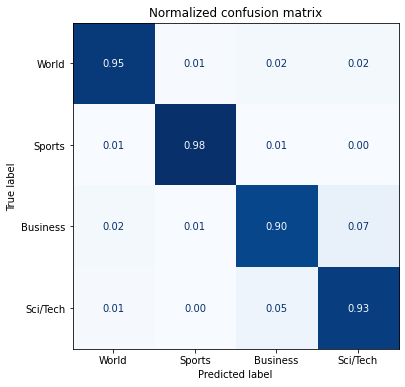

In [ ]:
plot_confusion_matrix(y_preds_trainer, y_valid, labels)


In [ ]:
from transformers import TFAutoModelForSequenceClassification

tf_model = (TFAutoModelForSequenceClassification
            .from_pretrained(model_ckpt, num_labels=num_labels))

Downloading:   0%|          | 0.00/347M [00:00<?, ?B/s]

In [ ]:
from torch.nn.functional import cross_entropy

def forward_pass_with_label(batch):
    # Place all input tensors on the same device as the model
    inputs = {k:v.to(device) for k,v in batch.items() 
              if k in tokenizer.model_input_names}

    with torch.no_grad():
        output = model(**inputs)
        pred_label = torch.argmax(output.logits, axis=-1)
        loss = cross_entropy(output.logits, batch["label"].to(device), 
                             reduction="none")

    # Place outputs on CPU for compatibility with other dataset columns   
    return {"loss": loss.cpu().numpy(), 
            "predicted_label": pred_label.cpu().numpy()}

In [ ]:
# Convert our dataset back to PyTorch tensors
news_encoded.set_format("torch", 
                            columns=["input_ids", "attention_mask", "label"])
# Compute loss values
news_encoded["validation"] = news_encoded["test"].map(
    forward_pass_with_label, batched=True, batch_size=16)

  0%|          | 0/475 [00:00<?, ?ba/s]

NameError: ignored

In [ ]:
news_encoded.set_format("pandas")
cols = ["text", "label", "predicted_label", "loss"]
df_test = news_encoded["validation"][:][cols]
df_test["label"] = df_test["label"].apply(label_int2str)
df_test["predicted_label"] = (df_test["predicted_label"]
                              .apply(label_int2str))

In [ ]:
df_test.sort_values("loss", ascending=False).head(10)
df_test.sort_values("loss", ascending=True).head(10)


In [ ]:
trainer.push_to_hub(commit_message="Training completed!")


Several commits (2) will be pushed upstream.
The progress bars may be unreliable.


Upload file pytorch_model.bin:   0%|          | 3.34k/255M [00:00<?, ?B/s]

Upload file runs/Jun17_09-48-49_880f6724b605/events.out.tfevents.1655459336.880f6724b605.281.0:  66%|######6  …

To https://huggingface.co/mosesju/distilbert-base-uncased-finetuned-news
   247bd85..5a6ced2  main -> main

To https://huggingface.co/mosesju/distilbert-base-uncased-finetuned-news
   5a6ced2..22d266c  main -> main



'https://huggingface.co/mosesju/distilbert-base-uncased-finetuned-news/commit/5a6ced2e49f1b766a314eb0a66e2f8896198d426'

In [ ]:
from transformers import pipeline

model_id = "mosesju/distilbert-base-uncased-finetuned-news"
classifier = pipeline("text-classification", model=model_id)

Downloading:   0%|          | 0.00/807 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/255M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/360 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/695k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/125 [00:00<?, ?B/s]

In [ ]:
test_story = "Russians control 80 percent of key Ukraine city, cut escape routes"
preds = classifier(test_story, return_all_scores=True)

/usr/local/lib/python3.7/dist-packages/transformers/pipelines/text_classification.py:90: UserWarning: `return_all_scores` is now deprecated, use `top_k=1` if you want similar functionnality
  "`return_all_scores` is now deprecated, use `top_k=1` if you want similar functionnality", UserWarning


In [ ]:
import pandas as pd

preds_df = pd.DataFrame(preds[0])
plt.bar(labels, 100 * preds_df["score"], color='C0')
plt.title(f'"{test_story}"')
plt.ylabel("Class probability (%)")
plt.show()

ValueError: ignored